In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; } </style>"))
display(HTML("<style>div.cell.selected {border-left-width: 0px !important;} </style>"))

In [39]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd

import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt

import random
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score , precision_score , recall_score ,silhouette_score , classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Softmax,Dropout
from tensorflow.keras.layers import LSTM,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

import math
import uuid
import random
import zipfile

! pip -q install phe
from phe import paillier



In [3]:
def split(data,test_size):
    X_train, X_val, ytrain, yval = train_test_split(data[0], data[1],test_size = 0.2,shuffle=False)
    y_train =to_categorical(ytrain)
    y_val=to_categorical(yval)
    return X_train, X_val, y_train, y_val

In [4]:
def one_hot(df,column):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(df[column]).toarray())
    final_df = df.join(encoder_df)
    final_df = final_df.drop(column,axis=1)
    return final_df

In [5]:
def create_local_clients( num_clients,initial='local_client'):
   
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    data=[]
    for i in range(num_clients):
        temp=pd.read_csv(r"C:\Users\sagar\Downloads\Processed_data_client"+'{}'.format(i+1)+".csv")
        temp=temp.sample(frac = 1)
        temp=temp.sample(frac = 1) 
        label=temp[['SQIM2_categorized']].copy()
        #label=one_hot(label_temp,['Category'])
        temp=temp[['EC','VWC','DP','temp']].copy()
        
        
        data.append((temp,label))
        
    shards = [data[i] for i in range(0, num_clients)]

    return {client_names[i] : shards[i] for i in range(len(client_names))}

num_local_clients=7
local_client_initial='local_client'
local_client_names = ['{}_{}'.format(local_client_initial, i+1) for i in range(num_local_clients)]
local_clients=create_local_clients(num_local_clients,local_client_initial)

train_test_local_clients=[]
for i in local_client_names:
    ret = split(local_clients[i],0.2)  
    train_test_local_clients.append(ret)

In [6]:
def create_global_clients(num_clients,initial='global_client'):
   
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    data=[]
    for i in range(num_clients):
        temp=pd.read_csv(r"C:\Users\sagar\OneDrive\Desktop\data_soil_downloads\all_weighted_classified_"+'{}'.format(i+1)+".csv")
        temp=temp.sample(frac = 1)
        temp=temp.sample(frac = 1)
        label=temp[['SQIM2_categorized']].copy()
        #label=one_hot(label_temp,['Category'])
        temp=temp[['SDTO', 'STPC', 'CLPC', 'BULK', 'ORGC', 'TOTN', 'CECS', 'BSAT', 'PHAQ',
       'TCEQ', 'ELCO', 'VWC', 'DP', 'Temp']].copy()
        data.append((temp,label))
        
    shards = [data[i] for i in range(0, num_clients)]

    return {client_names[i] : shards[i] for i in range(len(client_names))}

num_global_clients=1
global_client_initial='Global_client'
global_client_names = ['{}_{}'.format(global_client_initial, i+1) for i in range(num_global_clients)]
global_clients=create_global_clients(num_global_clients,global_client_initial)

train_test_global_clients=[]
for i in global_client_names:
    ret = split(global_clients[i],0.2)  
    train_test_global_clients.append(ret)
ret2=split(global_clients[i],0.2)

In [7]:
np.shape(train_test_local_clients[0][3])

(220, 4)

In [40]:
class Model_alpha:
    def build_global_model(self):
        normalizer = preprocessing.Normalization()
        model = tf.keras.Sequential()
        #model.add(normalizer)
        model.add(Dense(24,activation='relu',input_shape=(14,)))
        #model.add(Dropout(0.2))
        model.add(Dense(4))
        model.add(Activation("softmax"))
        return model
    def build_local_model(self):
        normalizer = preprocessing.Normalization()
        model = tf.keras.Sequential()
        #model.add(normalizer)
        model.add(Dense(24,activation='relu',input_shape=(4,)))
        #model.add(Dropout(0.2))
        model.add(Dense(4))
        model.add(Activation("softmax"))
        return model



def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


lr = 1e-3
loss='categorical_crossentropy'
# metrics = ['accuracy']
metrics=['acc',f1_m,precision_m, recall_m]
optimizer=keras.optimizers.Adam(learning_rate=lr)
#optimizer=tf.keras.optimizers.SGD(learning_rate=lr)
#optimizer = SGD(learning_rate=lr,decay=lr / comms_round,momentum=0.9)  

# optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# train_acc_metric = tf.keras.metrics.CategoricalAccuracy()

In [43]:
def scale_model_weights(weight, scalar):
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def Averaging_weights(length,layer1,gl1_w,gl1_b):
#     res_final=[]
    
#     to_avg_l3=[]
    to_avg_l1=[]
    bias_l1=[]
#     bias_l3=[]
    
    #gl1_w = gl1[0]
    #gl1_b =gl1[1]
    gl1_w1 = gl1_w[:-4]
    gl1_w2 = gl1_w[-4:]
    
    for i in range(length):
        to_avg_l1.append(layer1[i][0])
#         to_avg_l3.append(layer3[i][0])
        bias_l1.append(layer1[i][1])
#         bias_l3.append(layer3[i][1])
       
    x=0
    lwl1= np.array(to_avg_l1[0],dtype=object)
    lbl1=np.array(bias_l1[0],dtype=object)
#     lwl3= np.array(to_avg_l3[0],dtype=object)
#     lbl3=np.array(bias_l3[0],dtype=object)
    
    for i in range(1,length):
        lwl1 = np.add(lwl1,np.array(to_avg_l1[i]))
        lbl1 = np.add(lbl1,np.array(bias_l1[i]))
#         lwl3 = np.add(lwl3,np.array(to_avg_l3[i]))
#         lbl3 = np.add(lbl3,np.array(bias_l3[i]))
     #average of weights of commom attrrbutes of global and local clients' models 
    lwl1 = np.add(lwl1,np.array(gl1_w2,dtype=object))
    lwl1 = lwl1/(len(to_avg_l1)+1)
    lbl1 = lbl1/len(bias_l1)
#     lwl3 = lwl3/len(to_avg_l3)
#     lbl3 = lbl3/len(bias_l3)
    
    #preparation for global model
    lwl1=lwl1.tolist()
    gl1_w1=gl1_w1.tolist()
    gl1_w1_w2 =gl1_w1 + lwl1
    gl1_w1_w2=np.array(gl1_w1_w2)
    
    global_model_weights = []
    global_model_weights.append(gl1_w1_w2)
    global_model_weights.append(gl1_b)
    
    local_model_weights=[]
    local_model_weights.append(np.array(lwl1))
    local_model_weights.append(lbl1)
    
    #local_model_weights.append(lwl3)
    #local_model_weights.append(lbl3)
#     res_final.append(gl1_w1_w2)
#     res_final.append(lbl1)
#     res_final.append(lwl3)
#     res_final.append(lbl3)
    return global_model_weights , local_model_weights


def test_model_global(X_test, Y_test,  model, comm_round,client):
    lossfn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    output = model.predict(X_test)
    loss1 = lossfn(Y_test, output)
#     acc = accuracy_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1))
#     precision = precision_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1),average=None)
#     recall=recall_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1),average=None)
#     F1_Score = 2 * (precision * recall) / (precision + recall)
    loss, acc, F1_Score, precision, recall = model.evaluate(Y_test, output, verbose=0)
    print('comm_round: {} | client_name: {} | global_acc: {:.4%} | global_loss: {} | precision: {} | recall: {} | F1: {}'.format(comm_round,client, acc, loss, precision ,recall , F1_Score))
    return acc, loss1 

def test_model_local(X_test, Y_test,  model, comm_round,client):
    lossfn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    output = model.predict(X_test)
    loss1 = lossfn(Y_test, output)
    acc1 = accuracy_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1))
#     precision = precision_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1),average=None)
#     recall=recall_score(np.argmax(Y_test,axis=1), np.argmax(output, axis=1),average=None)
#     F1_Score = 2 * (precision * recall) / (precision + recall)
    loss, acc2, F1_Score, precision, recall = model.evaluate(Y_test, output, verbose=0)
    print(classification_report(np.argmax(Y_test,axis=1), np.argmax(output, axis=1)))
    print('comm_round: {} | client_name: {} | local_acc: {:.4%} {:.4%} | local_loss: {} | precision: {} | recall: {} | F1: {}'.format(comm_round,client, acc1,acc2, loss, precision, recall , F1_Score))
    return acc1, loss1 

In [11]:
#initialize global model
model_global = Model_alpha()
global_model = model_global.build_global_model()
global_model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
global_history=global_model.fit(train_test_global_clients[0][0],train_test_global_clients[0][2], epochs=200, verbose=1)

Epoch 1/200
363/363 [==============================] - 0s 547us/step - loss: 2.2354 - accuracy: 0.4465
Epoch 2/200
363/363 [==============================] - 0s 549us/step - loss: 1.0406 - accuracy: 0.5349
Epoch 3/200
363/363 [==============================] - 0s 552us/step - loss: 0.9799 - accuracy: 0.5593
Epoch 4/200
363/363 [==============================] - 0s 566us/step - loss: 0.9296 - accuracy: 0.5814
Epoch 5/200
363/363 [==============================] - 0s 549us/step - loss: 0.8949 - accuracy: 0.5994
Epoch 6/200
363/363 [==============================] - 0s 567us/step - loss: 0.8789 - accuracy: 0.6072
Epoch 7/200
363/363 [==============================] - 0s 564us/step - loss: 0.8642 - accuracy: 0.6114
Epoch 8/200
363/363 [==============================] - 0s 556us/step - loss: 0.8535 - accuracy: 0.6190
Epoch 9/200
363/363 [==============================] - 0s 550us/step - loss: 0.8311 - accuracy: 0.6290
Epoch 10/200
363/363 [==============================] - 0s 555us/step - l

363/363 [==============================] - 0s 573us/step - loss: 0.6335 - accuracy: 0.7249
Epoch 80/200
363/363 [==============================] - 0s 558us/step - loss: 0.6300 - accuracy: 0.7266
Epoch 81/200
363/363 [==============================] - 0s 570us/step - loss: 0.6300 - accuracy: 0.7216
Epoch 82/200
363/363 [==============================] - 0s 567us/step - loss: 0.6311 - accuracy: 0.7206
Epoch 83/200
363/363 [==============================] - 0s 563us/step - loss: 0.6292 - accuracy: 0.7233
Epoch 84/200
363/363 [==============================] - 0s 558us/step - loss: 0.6277 - accuracy: 0.7269
Epoch 85/200
363/363 [==============================] - 0s 570us/step - loss: 0.6250 - accuracy: 0.7228
Epoch 86/200
363/363 [==============================] - 0s 570us/step - loss: 0.6243 - accuracy: 0.7286
Epoch 87/200
363/363 [==============================] - 0s 569us/step - loss: 0.6177 - accuracy: 0.7280
Epoch 88/200
363/363 [==============================] - 0s 569us/step - loss:

363/363 [==============================] - 0s 576us/step - loss: 0.5748 - accuracy: 0.7450
Epoch 158/200
363/363 [==============================] - 0s 567us/step - loss: 0.5692 - accuracy: 0.7510
Epoch 159/200
363/363 [==============================] - 0s 567us/step - loss: 0.5695 - accuracy: 0.7503
Epoch 160/200
363/363 [==============================] - 0s 565us/step - loss: 0.5682 - accuracy: 0.7513
Epoch 161/200
363/363 [==============================] - 0s 571us/step - loss: 0.5658 - accuracy: 0.7538
Epoch 162/200
363/363 [==============================] - 0s 559us/step - loss: 0.5668 - accuracy: 0.7481
Epoch 163/200
363/363 [==============================] - 0s 560us/step - loss: 0.5751 - accuracy: 0.7451
Epoch 164/200
363/363 [==============================] - 0s 564us/step - loss: 0.5663 - accuracy: 0.7493
Epoch 165/200
363/363 [==============================] - 0s 558us/step - loss: 0.5711 - accuracy: 0.7501
Epoch 166/200
363/363 [==============================] - 0s 561us/ste

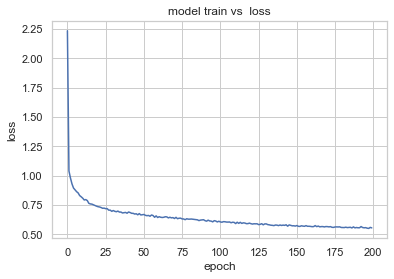

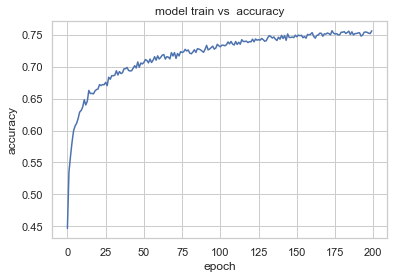

In [12]:
fig1=plt.figure()
plt.plot(global_history.history['loss'])
plt.title('model train vs  loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
fig2=plt.figure()
plt.plot(global_history.history['accuracy'])
plt.title('model train vs  accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.54      0.72      0.62        54
           2       0.60      0.47      0.52       116
           3       0.45      0.54      0.49        48

    accuracy                           0.54       220
   macro avg       0.40      0.43      0.41       220
weighted avg       0.55      0.54      0.54       220

comm_round: -1 | client_name: local_client_1 | local_acc: 54.0909% 32.7273% | local_loss: 1.4160196781158447 | precision: 0.0 | recall: 0.0 | F1: 0.0


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: Unde

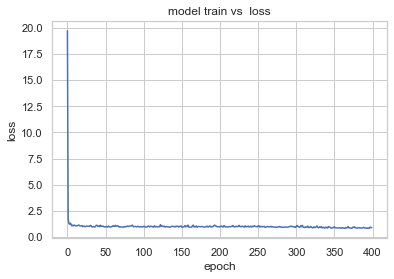

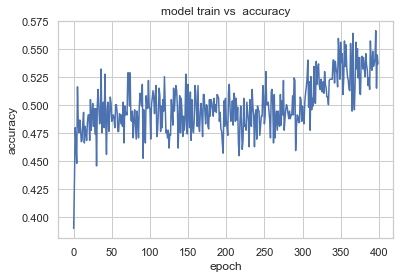

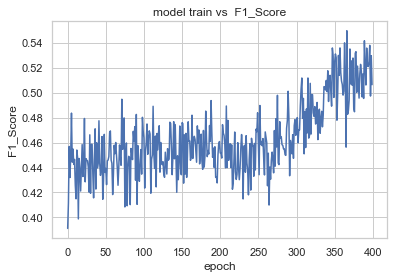

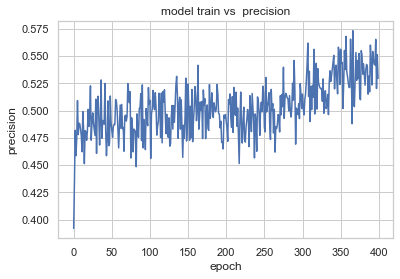

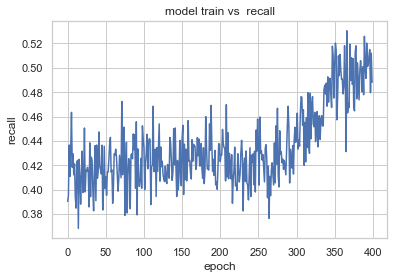

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.98      0.95      0.96        99
           2       0.89      0.98      0.93        65
           3       1.00      0.86      0.93        22

    accuracy                           0.95       187
   macro avg       0.72      0.70      0.71       187
weighted avg       0.95      0.95      0.94       187

comm_round: -1 | client_name: local_client_2 | local_acc: 94.6524% 10.1604% | local_loss: 2.3608717918395996 | precision: 0.10185185074806213 | recall: 0.10185185074806213 | F1: 0.10185179859399796


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: Unde

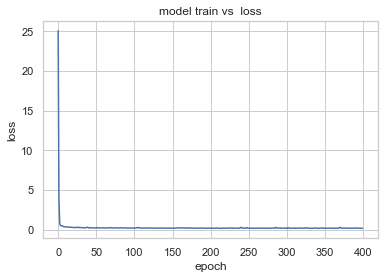

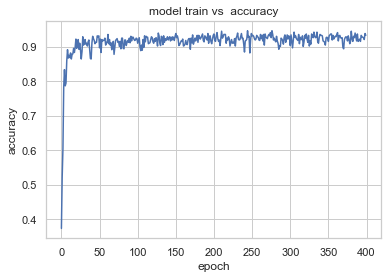

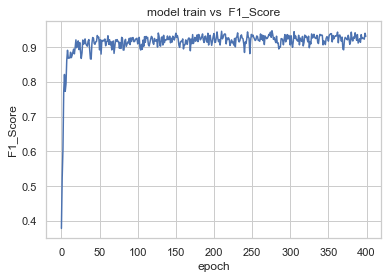

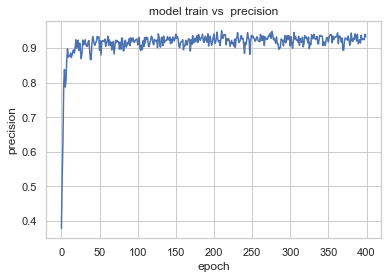

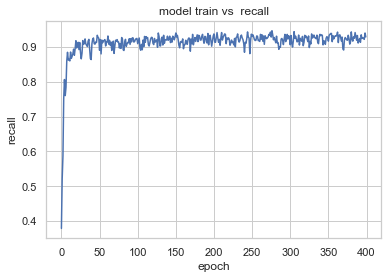

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00        24
           2       0.75      0.82      0.78       113
           3       0.60      0.76      0.67        49

    accuracy                           0.70       188
   macro avg       0.59      0.64      0.61       188
weighted avg       0.62      0.70      0.66       188

comm_round: -1 | client_name: local_client_3 | local_acc: 70.2128% 65.9574% | local_loss: 1.5678038597106934 | precision: 0.0848214328289032 | recall: 0.09251400083303452 | F1: 0.08849582076072693


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: Unde

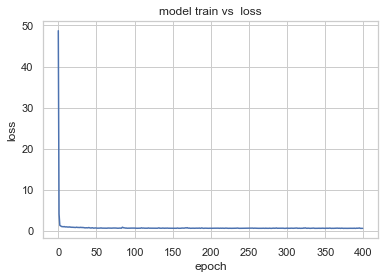

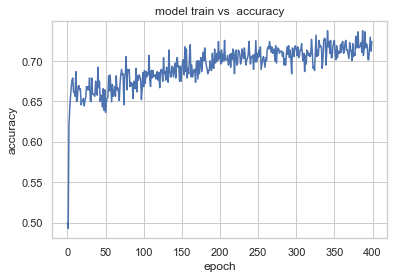

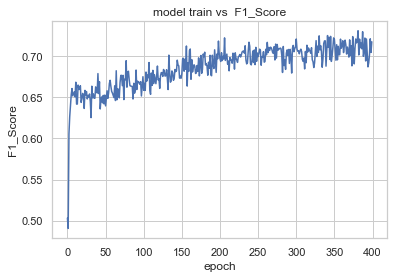

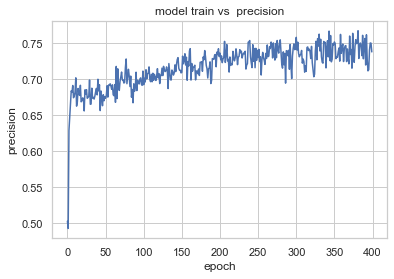

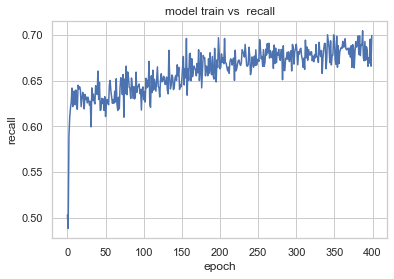

              precision    recall  f1-score   support

           0       0.53      0.98      0.68        53
           1       0.00      0.00      0.00        55
           2       0.89      0.97      0.93        77
           3       0.50      0.75      0.60         4

    accuracy                           0.69       189
   macro avg       0.48      0.68      0.55       189
weighted avg       0.52      0.69      0.58       189

comm_round: -1 | client_name: local_client_4 | local_acc: 68.7831% 0.0000% | local_loss: 2.6405372619628906 | precision: 0.0 | recall: 0.0 | F1: 0.0


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: Unde

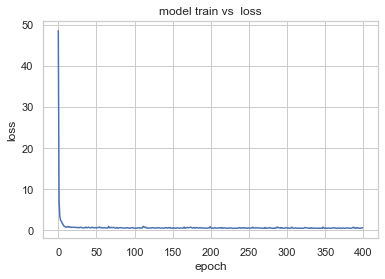

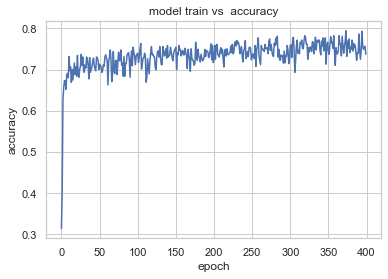

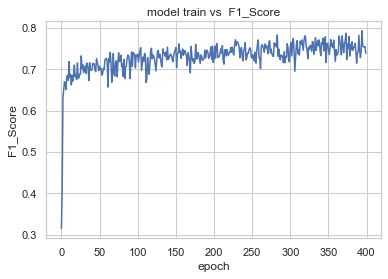

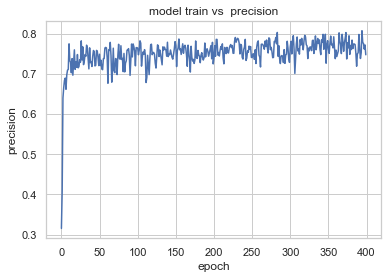

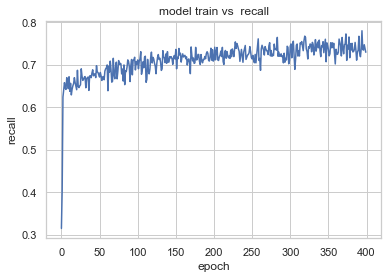

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       1.00      0.69      0.82        93
           2       0.69      1.00      0.82        87
           3       0.00      0.00      0.00         3

    accuracy                           0.79       190
   macro avg       0.42      0.42      0.41       190
weighted avg       0.81      0.79      0.77       190

comm_round: -1 | client_name: local_client_5 | local_acc: 79.4737% 33.6842% | local_loss: 2.6978540420532227 | precision: 0.2788194417953491 | recall: 0.30784520506858826 | F1: 0.29237642884254456


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: Unde

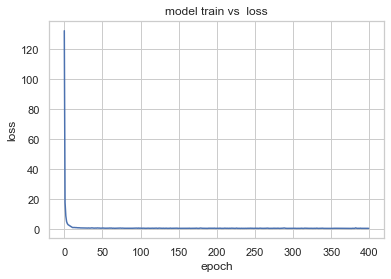

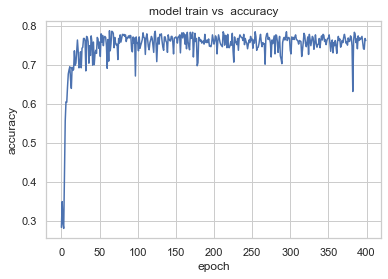

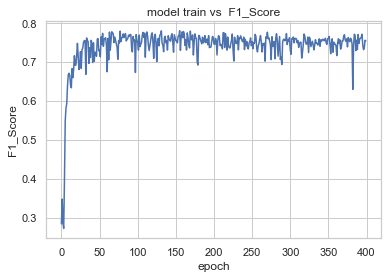

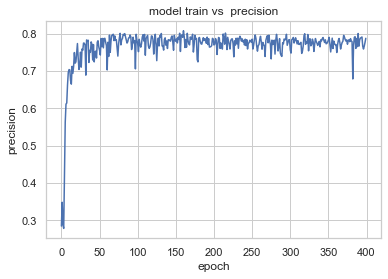

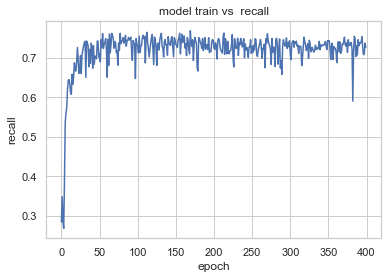

              precision    recall  f1-score   support

           0       0.64      1.00      0.78        14
           1       0.99      0.78      0.87        97
           2       0.85      0.88      0.87        69
           3       0.54      0.82      0.65        17

    accuracy                           0.84       197
   macro avg       0.75      0.87      0.79       197
weighted avg       0.87      0.84      0.84       197

comm_round: -1 | client_name: local_client_6 | local_acc: 83.7563% 39.0863% | local_loss: 3.4041178226470947 | precision: 0.3678571581840515 | recall: 0.3698732852935791 | F1: 0.3688491880893707


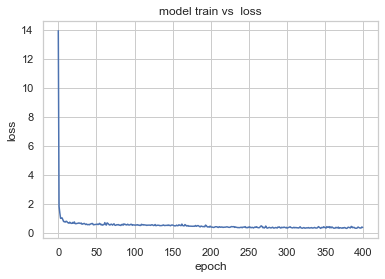

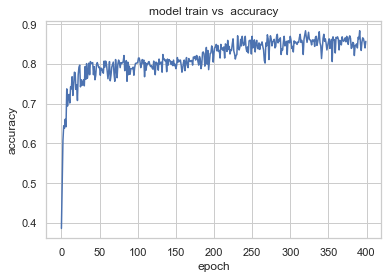

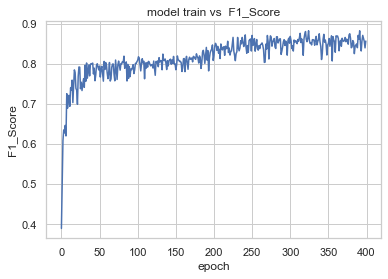

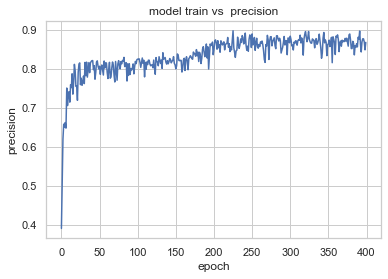

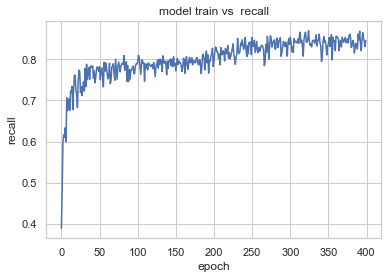

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        29
           1       0.89      0.85      0.87        67
           2       0.90      1.00      0.95        93
           3       0.00      0.00      0.00         5

    accuracy                           0.89       194
   macro avg       0.65      0.65      0.65       194
weighted avg       0.86      0.89      0.87       194

comm_round: -1 | client_name: local_client_7 | local_acc: 88.6598% 32.9897% | local_loss: 1.6180449724197388 | precision: 0.2053571492433548 | recall: 0.21004223823547363 | F1: 0.20764295756816864


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: Unde

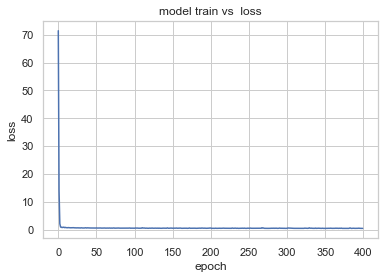

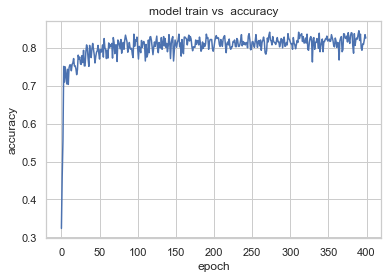

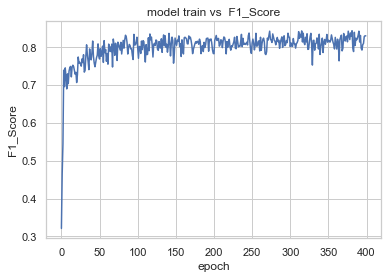

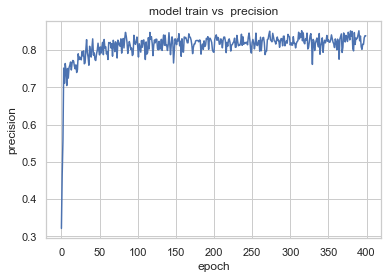

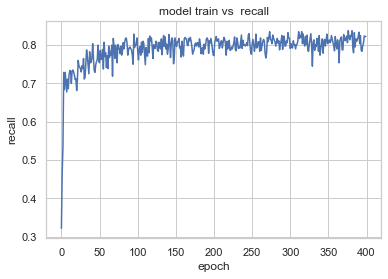

In [44]:
client_names= list(local_clients.keys())
for i,client in enumerate(client_names):
    model_local = Model_alpha()
    local_model = model_local.build_local_model()
    local_model.compile(loss=loss, 
                optimizer=optimizer, 
                metrics=metrics)
        
    #fit local model with client's data
    comm_round = -1
    local_history=local_model.fit(train_test_local_clients[i][0],train_test_local_clients[i][2], epochs=400, verbose=0)
    local_acc, local_loss = test_model_local(train_test_local_clients[i][1], train_test_local_clients[i][3],local_model, comm_round,client)
    fig1=plt.figure()
    plt.plot(local_history.history['loss'])
    plt.title('model train vs  loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    fig2=plt.figure()
    plt.plot(local_history.history['acc'])
    plt.title('model train vs  accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()
    fig3=plt.figure()
    plt.plot(local_history.history['f1_m'])
    plt.title('model train vs  F1_Score')
    plt.ylabel('F1_Score')
    plt.xlabel('epoch')
    plt.show()
    fig4=plt.figure()
    plt.plot(local_history.history['precision_m'])
    plt.title('model train vs  precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.show()
    fig5=plt.figure()
    plt.plot(local_history.history['recall_m'])
    plt.title('model train vs  recall')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.show()

In [28]:
local_history.history

{'loss': [21.19564437866211,
  2.188601493835449,
  1.5795543193817139,
  1.5165400505065918,
  1.4313422441482544,
  1.3540233373641968,
  1.3095293045043945,
  1.2330374717712402,
  1.2336032390594482,
  1.1687167882919312,
  1.1482900381088257,
  1.1266405582427979,
  1.0924499034881592,
  1.0298300981521606,
  1.0489821434020996,
  0.9606464505195618,
  0.9618973731994629,
  0.8989030718803406,
  0.9120782017707825,
  0.8753451704978943,
  0.8787409663200378,
  0.9146088361740112,
  0.869769811630249,
  0.8623543381690979,
  0.8460813164710999,
  0.8612486720085144,
  0.8367493152618408,
  0.8236920237541199,
  0.8485586643218994,
  0.8367936611175537,
  0.9164632558822632,
  0.8659807443618774,
  0.8304897546768188,
  0.8360220789909363,
  0.8490270972251892,
  0.8370291590690613,
  0.8183384537696838,
  0.8648806214332581,
  0.8193236589431763,
  0.8107521533966064,
  0.8912535905838013,
  0.8254435658454895,
  0.8243041634559631,
  0.7987895011901855,
  0.8115320801734924,
  0.8

In [14]:

# global_layer1_weight  = global_model.layers[0].get_weights()[0]
# global_layer1_bias=global_model.layers[0].get_weights()[1]
# global_weight_layer_1=[]
# global_weight_layer_1.append(global_layer1_weight[-4:])
# global_weight_layer_1.append(global_layer1_bias)
# K.clear_session()

In [19]:
comms_round = 10
for comm_round in range(comms_round):
    print(comm_round)
    if comm_round>0:
        global_model.layers[0].set_weights(global_weights_new)
    global_model.fit(train_test_global_clients[0][0], train_test_global_clients[0][2],epochs=100, verbose=0)
    # get the global model's weights 
    global_layer1_weight  = global_model.layers[0].get_weights()[0]
    global_layer1_bias=global_model.layers[0].get_weights()[1]
    global_weight_layer_1=[]
    global_weight_layer_1.append(global_layer1_weight[-4:])
    global_weight_layer_1.append(global_layer1_bias)
        #global_weights_2 = np.array(global_model.layers[2].get_weights(),dtype=object)
    local_weight_list_layer1 = []
    local_weight_list_layer3 = []

    #randomize client data - using keys
    client_names= list(local_clients.keys())
    
    #loop through each client and create new local model
    for i,client in enumerate(client_names):
        model_local = Model_alpha()
        local_model = model_local.build_local_model()
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        if comm_round >0 :
            local_model.layers[0].set_weights(local_weights_new)
        #set local model weight to the weight of the global model
        #ex=local_model.get_weights()
        #local_model.layers[0].set_weights(global_weight_layer_1)
        #local_model.layers[2].set_weights(global_weights_2)
        
        #fit local model with client's data
        local_model.fit(train_test_local_clients[i][0],train_test_local_clients[i][2], epochs=100, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = 1 #0.3
        scaled_weights_layer1 = scale_model_weights(np.array(local_model.layers[0].get_weights(),dtype=object), scaling_factor)
        local_weight_list_layer1.append(scaled_weights_layer1)
#         scaled_weights_layer3 = scale_model_weights(np.array(local_model.layers[2].get_weights(),dtype=object),scaling_factor)
#         local_weight_list_layer3.append(scaled_weights_layer3)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #test global model and print out metrics after each communications round
    avg_local_acc=0
    global_client_names= list(global_clients.keys())
    for i,client in enumerate(global_client_names):
        global_acc, global_loss = test_model_global(train_test_global_clients[i][1], train_test_global_clients[i][3], global_model, comm_round,client)
    local_client_names= list(local_clients.keys())
    for i,client in enumerate(local_client_names):
        local_acc, local_loss = test_model_local(train_test_local_clients[i][1], train_test_local_clients[i][3],local_model, comm_round,client)
        avg_local_acc+=local_acc
    print("Average Local Clients Accuracy : {:.4%}".format(avg_local_acc/7))
    
    #the average over all the local model
    global_weights_new , local_weights_new = Averaging_weights(len(local_client_names),local_weight_list_layer1 , global_layer1_weight , global_layer1_bias)
    
    #update global and local model 
    global_model.layers[0].set_weights(global_weights_new)
    local_model.layers[0].set_weights(local_weights_new)
    
       

0
comm_round: 0 | client_name: Global_client_1 | global_acc: 76.1642% | global_loss: 1.010513424873352 | precision: [0.741 0.764 0.744 0.8  ] | recall: [0.899 0.546 0.78  0.852] | F1: [0.813 0.637 0.762 0.825]
comm_round: 0 | client_name: local_client_1 | local_acc: 40.9091% | local_loss: 1.2987282276153564 | precision: [0.062 0.429 0.54  0.158] | recall: [1.    0.444 0.526 0.062] | F1: [0.118 0.436 0.533 0.09 ]
comm_round: 0 | client_name: local_client_2 | local_acc: 59.8930% | local_loss: 1.0926167964935303 | precision: [0.024 1.    0.65  0.   ] | recall: [1.    0.465 1.    0.   ] | F1: [0.048 0.634 0.788   nan]
comm_round: 0 | client_name: local_client_3 | local_acc: 29.7872% | local_loss: 1.3677198886871338 | precision: [0.    0.182 0.5   0.487] | recall: [0.    0.25  0.274 0.388] | F1: [  nan 0.211 0.354 0.432]
comm_round: 0 | client_name: local_client_4 | local_acc: 64.5503% | local_loss: 1.0910260677337646 | precision: [1.    0.513 0.755 0.429] | recall: [0.038 0.727 1.    0.75 

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classifica

comm_round: 0 | client_name: local_client_6 | local_acc: 71.0660% | local_loss: 1.1014224290847778 | precision: [0.    0.859 0.714 0.421] | recall: [0.    0.691 0.942 0.471] | F1: [  nan 0.766 0.812 0.444]
comm_round: 0 | client_name: local_client_7 | local_acc: 81.4433% | local_loss: 0.988945484161377 | precision: [0.783 0.81  0.823 0.   ] | recall: [0.621 0.701 1.    0.   ] | F1: [0.692 0.752 0.903   nan]
Average Local Clients Accuracy : 60.3408%
1
comm_round: 1 | client_name: Global_client_1 | global_acc: 75.8192% | global_loss: 1.0147470235824585 | precision: [0.89  0.689 0.716 0.81 ] | recall: [0.716 0.641 0.798 0.848] | F1: [0.794 0.664 0.755 0.828]
comm_round: 1 | client_name: local_client_1 | local_acc: 44.5455% | local_loss: 1.2636921405792236 | precision: [0.    0.426 0.561 0.   ] | recall: [0.    0.37  0.672 0.   ] | F1: [  nan 0.396 0.612   nan]
comm_round: 1 | client_name: local_client_2 | local_acc: 70.0535% | local_loss: 1.0294080972671509 | precision: [0.    0.985 0.657

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: R

comm_round: 1 | client_name: local_client_6 | local_acc: 73.0964% | local_loss: 1.0681967735290527 | precision: [0.    0.83  0.725 0.333] | recall: [0.    0.753 0.957 0.294] | F1: [  nan 0.789 0.825 0.312]
comm_round: 1 | client_name: local_client_7 | local_acc: 78.3505% | local_loss: 0.9649993777275085 | precision: [0.    0.67  0.877 0.   ] | recall: [0.    0.881 1.    0.   ] | F1: [  nan 0.761 0.935   nan]
Average Local Clients Accuracy : 63.7442%
2


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


comm_round: 2 | client_name: Global_client_1 | global_acc: 76.7161% | global_loss: 1.004172921180725 | precision: [0.837 0.681 0.745 0.844] | recall: [0.827 0.725 0.742 0.801] | F1: [0.832 0.702 0.744 0.822]
comm_round: 2 | client_name: local_client_1 | local_acc: 45.0000% | local_loss: 1.2601088285446167 | precision: [0.    0.42  0.561 0.   ] | recall: [0.    0.389 0.672 0.   ] | F1: [  nan 0.404 0.612   nan]
comm_round: 2 | client_name: local_client_2 | local_acc: 67.3797% | local_loss: 1.0360643863677979 | precision: [0.    0.984 0.663 0.   ] | recall: [0.    0.616 1.    0.   ] | F1: [  nan 0.758 0.798   nan]
comm_round: 2 | client_name: local_client_3 | local_acc: 30.3191% | local_loss: 1.3751801252365112 | precision: [0.    0.318 0.475 0.143] | recall: [0.    0.292 0.416 0.061] | F1: [  nan 0.304 0.443 0.086]
comm_round: 2 | client_name: local_client_4 | local_acc: 65.6085% | local_loss: 1.1016243696212769 | precision: [0.    0.486 0.934 0.   ] | recall: [0.    0.964 0.922 0.   ] 

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: R

comm_round: 2 | client_name: local_client_6 | local_acc: 73.6041% | local_loss: 1.0796518325805664 | precision: [0.    0.83  0.733 0.375] | recall: [0.    0.753 0.957 0.353] | F1: [  nan 0.789 0.83  0.364]
comm_round: 2 | client_name: local_client_7 | local_acc: 79.3814% | local_loss: 0.965832531452179 | precision: [0.    0.678 0.894 0.   ] | recall: [0.   0.91 1.   0.  ] | F1: [  nan 0.777 0.944   nan]
Average Local Clients Accuracy : 63.2674%
3


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


comm_round: 3 | client_name: Global_client_1 | global_acc: 77.3025% | global_loss: 1.0010483264923096 | precision: [0.767 0.691 0.764 0.878] | recall: [0.922 0.678 0.744 0.803] | F1: [0.837 0.684 0.754 0.839]
comm_round: 3 | client_name: local_client_1 | local_acc: 45.4545% | local_loss: 1.2549831867218018 | precision: [0.074 0.465 0.549 0.   ] | recall: [1.    0.37  0.672 0.   ] | F1: [0.138 0.412 0.605   nan]
comm_round: 3 | client_name: local_client_2 | local_acc: 64.1711% | local_loss: 1.0548326969146729 | precision: [0.028 0.982 0.674 0.   ] | recall: [1.    0.556 0.985 0.   ] | F1: [0.054 0.71  0.8     nan]
comm_round: 3 | client_name: local_client_3 | local_acc: 35.6383% | local_loss: 1.3465142250061035 | precision: [0.    0.35  0.492 0.   ] | recall: [0.    0.292 0.531 0.   ] | F1: [  nan 0.318 0.511   nan]
comm_round: 3 | client_name: local_client_4 | local_acc: 60.8466% | local_loss: 1.1224477291107178 | precision: [0.    0.45  0.897 0.   ] | recall: [0.    0.982 0.792 0.   ]

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: R

comm_round: 3 | client_name: local_client_6 | local_acc: 71.5736% | local_loss: 1.0978660583496094 | precision: [0.    0.811 0.692 0.125] | recall: [0.    0.794 0.913 0.059] | F1: [  nan 0.802 0.787 0.08 ]
comm_round: 3 | client_name: local_client_7 | local_acc: 79.3814% | local_loss: 0.9696757793426514 | precision: [0.    0.66  0.936 0.   ] | recall: [0.    0.985 0.946 0.   ] | F1: [  nan 0.79  0.941   nan]
Average Local Clients Accuracy : 63.1898%
4


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


comm_round: 4 | client_name: Global_client_1 | global_acc: 78.2339% | global_loss: 0.9934600591659546 | precision: [0.899 0.685 0.746 0.879] | recall: [0.771 0.75  0.794 0.807] | F1: [0.83  0.716 0.769 0.841]
comm_round: 4 | client_name: local_client_1 | local_acc: 43.1818% | local_loss: 1.2863950729370117 | precision: [0.041 0.645 0.562 0.   ] | recall: [1.    0.37  0.629 0.   ] | F1: [0.078 0.471 0.593   nan]
comm_round: 4 | client_name: local_client_2 | local_acc: 62.0321% | local_loss: 1.0633060932159424 | precision: [0.024 0.981 0.681 0.   ] | recall: [1.    0.515 0.985 0.   ] | F1: [0.048 0.675 0.805   nan]
comm_round: 4 | client_name: local_client_3 | local_acc: 26.5957% | local_loss: 1.4089975357055664 | precision: [0.    0.636 0.443 0.   ] | recall: [0.    0.292 0.381 0.   ] | F1: [ nan 0.4  0.41  nan]
comm_round: 4 | client_name: local_client_4 | local_acc: 62.9630% | local_loss: 1.1062511205673218 | precision: [0.    0.466 0.942 0.   ] | recall: [0.    0.982 0.844 0.   ] | F

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: R

comm_round: 4 | client_name: local_client_6 | local_acc: 73.6041% | local_loss: 1.0905275344848633 | precision: [0.    0.831 0.774 0.375] | recall: [0.    0.763 0.942 0.353] | F1: [  nan 0.796 0.85  0.364]
comm_round: 4 | client_name: local_client_7 | local_acc: 80.4124% | local_loss: 0.9576431512832642 | precision: [0.    0.681 0.939 0.   ] | recall: [0.    0.955 0.989 0.   ] | F1: [  nan 0.795 0.963   nan]
Average Local Clients Accuracy : 61.5563%
5


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


comm_round: 5 | client_name: Global_client_1 | global_acc: 79.1997% | global_loss: 0.9892477989196777 | precision: [0.827 0.737 0.752 0.887] | recall: [0.897 0.704 0.8   0.794] | F1: [0.861 0.72  0.775 0.838]
comm_round: 5 | client_name: local_client_1 | local_acc: 45.0000% | local_loss: 1.2631292343139648 | precision: [0.034 1.    0.581 0.   ] | recall: [1.    0.204 0.741 0.   ] | F1: [0.066 0.338 0.652   nan]
comm_round: 5 | client_name: local_client_2 | local_acc: 59.8930% | local_loss: 1.1262922286987305 | precision: [0.024 0.979 0.66  0.   ] | recall: [1.    0.475 0.985 0.   ] | F1: [0.047 0.639 0.79    nan]
comm_round: 5 | client_name: local_client_3 | local_acc: 35.6383% | local_loss: 1.343588948249817 | precision: [0.    0.7   0.484 0.   ] | recall: [0.    0.292 0.531 0.   ] | F1: [  nan 0.412 0.506   nan]
comm_round: 5 | client_name: local_client_4 | local_acc: 62.4339% | local_loss: 1.1153682470321655 | precision: [1.    0.461 0.928 0.   ] | recall: [0.019 0.964 0.831 0.   ] 

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classifica

comm_round: 5 | client_name: local_client_6 | local_acc: 64.9746% | local_loss: 1.1605805158615112 | precision: [0.    0.8   0.636 0.   ] | recall: [0.    0.619 0.986 0.   ] | F1: [  nan 0.698 0.773   nan]
comm_round: 5 | client_name: local_client_7 | local_acc: 89.6907% | local_loss: 0.9767691493034363 | precision: [0.828 0.919 0.903 0.   ] | recall: [0.828 0.851 1.    0.   ] | F1: [0.828 0.884 0.949   nan]
Average Local Clients Accuracy : 62.5938%
6


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


comm_round: 6 | client_name: Global_client_1 | global_acc: 77.9924% | global_loss: 0.9928069114685059 | precision: [0.864 0.691 0.739 0.903] | recall: [0.807 0.755 0.804 0.752] | F1: [0.835 0.722 0.77  0.821]
comm_round: 6 | client_name: local_client_1 | local_acc: 40.0000% | local_loss: 1.2956124544143677 | precision: [0.03  1.    0.561 0.   ] | recall: [1.    0.222 0.638 0.   ] | F1: [0.059 0.364 0.597   nan]
comm_round: 6 | client_name: local_client_2 | local_acc: 60.9626% | local_loss: 1.0893547534942627 | precision: [0.023 0.98  0.681 0.   ] | recall: [1.    0.495 0.985 0.   ] | F1: [0.045 0.658 0.805   nan]
comm_round: 6 | client_name: local_client_3 | local_acc: 28.7234% | local_loss: 1.3799841403961182 | precision: [0.    1.    0.457 0.182] | recall: [0.    0.292 0.381 0.082] | F1: [  nan 0.452 0.415 0.113]
comm_round: 6 | client_name: local_client_4 | local_acc: 64.5503% | local_loss: 1.1078376770019531 | precision: [0.    0.466 0.985 0.429] | recall: [0.    0.982 0.844 0.75 ]

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: R

comm_round: 6 | client_name: local_client_6 | local_acc: 70.0508% | local_loss: 1.124416470527649 | precision: [0.    0.817 0.756 0.375] | recall: [0.    0.691 0.942 0.353] | F1: [  nan 0.749 0.839 0.364]
comm_round: 6 | client_name: local_client_7 | local_acc: 82.9897% | local_loss: 0.9696006178855896 | precision: [0.583 0.735 0.939 0.   ] | recall: [0.241 0.91  1.    0.   ] | F1: [0.341 0.813 0.969   nan]
Average Local Clients Accuracy : 61.3403%
7


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


comm_round: 7 | client_name: Global_client_1 | global_acc: 78.9238% | global_loss: 0.9908375144004822 | precision: [0.853 0.685 0.794 0.858] | recall: [0.853 0.787 0.721 0.842] | F1: [0.853 0.732 0.756 0.85 ]
comm_round: 7 | client_name: local_client_1 | local_acc: 46.8182% | local_loss: 1.253077507019043 | precision: [0.    0.426 0.572 0.   ] | recall: [0.    0.37  0.716 0.   ] | F1: [  nan 0.396 0.636   nan]
comm_round: 7 | client_name: local_client_2 | local_acc: 72.7273% | local_loss: 1.017325758934021 | precision: [0.    0.961 0.677 0.   ] | recall: [0.    0.737 0.969 0.   ] | F1: [  nan 0.834 0.797   nan]
comm_round: 7 | client_name: local_client_3 | local_acc: 34.5745% | local_loss: 1.364214301109314 | precision: [0.    0.474 0.479 0.   ] | recall: [0.    0.375 0.496 0.   ] | F1: [  nan 0.419 0.487   nan]
comm_round: 7 | client_name: local_client_4 | local_acc: 59.7884% | local_loss: 1.1447176933288574 | precision: [0.    0.443 0.881 0.   ] | recall: [0.    0.982 0.766 0.   ] | 

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

comm_round: 7 | client_name: local_client_6 | local_acc: 73.0964% | local_loss: 1.084417462348938 | precision: [0.    0.814 0.67  0.   ] | recall: [0.    0.814 0.942 0.   ] | F1: [  nan 0.814 0.783   nan]
comm_round: 7 | client_name: local_client_7 | local_acc: 77.3196% | local_loss: 0.9909206032752991 | precision: [0.    0.635 0.933 0.   ] | recall: [0.    0.985 0.903 0.   ] | F1: [  nan 0.772 0.918   nan]
Average Local Clients Accuracy : 64.0012%
8


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


comm_round: 8 | client_name: Global_client_1 | global_acc: 78.9928% | global_loss: 0.9864205718040466 | precision: [0.802 0.758 0.743 0.899] | recall: [0.924 0.695 0.818 0.75 ] | F1: [0.859 0.725 0.779 0.818]
comm_round: 8 | client_name: local_client_1 | local_acc: 51.3636% | local_loss: 1.23064386844635 | precision: [0.    0.459 0.567 0.   ] | recall: [0.    0.519 0.733 0.   ] | F1: [  nan 0.487 0.639   nan]
comm_round: 8 | client_name: local_client_2 | local_acc: 80.2139% | local_loss: 1.0552680492401123 | precision: [0.    0.988 0.644 0.   ] | recall: [0.    0.859 1.    0.   ] | F1: [  nan 0.919 0.783   nan]
comm_round: 8 | client_name: local_client_3 | local_acc: 38.2979% | local_loss: 1.3415056467056274 | precision: [0.  0.2 0.5 0. ] | recall: [0.    0.25  0.584 0.   ] | F1: [  nan 0.222 0.539   nan]
comm_round: 8 | client_name: local_client_4 | local_acc: 65.0794% | local_loss: 1.1009392738342285 | precision: [0.    0.472 0.88  0.   ] | recall: [0.    0.909 0.948 0.   ] | F1: [  

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

comm_round: 8 | client_name: local_client_6 | local_acc: 70.0508% | local_loss: 1.1081187725067139 | precision: [0.    0.831 0.616 0.   ] | recall: [0.    0.711 1.    0.   ] | F1: [  nan 0.767 0.762   nan]
comm_round: 8 | client_name: local_client_7 | local_acc: 76.2887% | local_loss: 0.9874498248100281 | precision: [0.    0.655 0.845 0.   ] | recall: [0.    0.821 1.    0.   ] | F1: [  nan 0.728 0.916   nan]
Average Local Clients Accuracy : 66.5007%
9


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


comm_round: 9 | client_name: Global_client_1 | global_acc: 78.8548% | global_loss: 0.9865893721580505 | precision: [0.842 0.699 0.758 0.907] | recall: [0.845 0.747 0.795 0.781] | F1: [0.843 0.722 0.776 0.839]
comm_round: 9 | client_name: local_client_1 | local_acc: 42.2727% | local_loss: 1.2869009971618652 | precision: [0.042 0.588 0.555 0.   ] | recall: [1.    0.37  0.612 0.   ] | F1: [0.08  0.455 0.582   nan]


C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


comm_round: 9 | client_name: local_client_2 | local_acc: 61.4973% | local_loss: 1.0851480960845947 | precision: [0.024 1.    0.677 0.   ] | recall: [1.    0.495 1.    0.   ] | F1: [0.047 0.662 0.807   nan]
comm_round: 9 | client_name: local_client_3 | local_acc: 27.1277% | local_loss: 1.383957862854004 | precision: [0.    0.636 0.473 0.   ] | recall: [0.    0.292 0.389 0.   ] | F1: [  nan 0.4   0.427   nan]
comm_round: 9 | client_name: local_client_4 | local_acc: 65.0794% | local_loss: 1.0850554704666138 | precision: [1.    0.472 0.886 0.667] | recall: [0.019 0.909 0.909 0.5  ] | F1: [0.037 0.621 0.897 0.571]
comm_round: 9 | client_name: local_client_5 | local_acc: 78.9474% | local_loss: 1.0241434574127197 | precision: [0.071 0.97  0.773 0.   ] | recall: [0.143 0.688 0.977 0.   ] | F1: [0.095 0.805 0.863   nan]
comm_round: 9 | client_name: local_client_6 | local_acc: 71.5736% | local_loss: 1.1022506952285767 | precision: [0.    0.824 0.756 0.375] | recall: [0.    0.722 0.942 0.353] | F

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classifica